In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statistics
#from function import *
import statsmodels.api as sm
from datetime import datetime, timedelta
import time
from btbase import *

In [2]:
class train:
    
    # 初始化
    def __init__(self):
        self.dataframe = None
        self.data_laundry = None
        self.start_time = None
        self.end_time = None
    
    # 通过平台api获取数据
    def set_data(self, s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None):
        # 获取数据api
        self.dataframe = get_crypto_price(s_time, e_time, symbols=symbol_, fields=None, bar_type="1m", offset=None, engine_info=None)
        # 把收益率加入到dataframe中
        self.dataframe = self.dataframe.assign(return_close= self.dataframe['close'].pct_change() * 100)
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0]
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
    
    # 通过dataframe文件获取数据
    def set_data_df(self, dataframe):
        # 本地dataframe
        self.dataframe = dataframe  
        # 把收益率加入到dataframe中 
        self.dataframe = self.dataframe.assign(return_close= self.dataframe['close'].pct_change() * 100) 
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0] 
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
        
    
    # 方程用来得到相应步长的volatility
    # 结果是顺序的dataframe包含每个以小时为单位的区间volatility
    def get_volatility(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        volatility = []
        # 在dataframe中取出相应区间的收益率并计算标准差得到volatility
        for i in hour_table.index:
            volatility.append(np.var(self.dataframe['return_close'][(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])].dropna()))
        # 加入dataframe
        hour_table['volatility'] = volatility
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)
        

    # 计算每个区间头尾的收益率的平方(Rt^2)
    # Rt = (Pt - Pt-1)/Pt-1
    # 这里t以timestep为单位
    def get_return_square(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        
        return_square = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            # 根据hour_table的starttime和endtime取出相应的dataframe
            close = self.dataframe['close'][(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])].dropna()
            # Rt^2 = ((Pt - Pt-1)/Pt-1)^2
            return_square.append(((close.values[0] - close.values[-1] )/ close.values[0])**2)
            #return_square.append((np.log(close.values[0]/close.values[-1]))**2)

        # 加入dataframe
        hour_table['return_square'] = return_square
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)

    # 得到模型
    # order: 每个变量的阶数
    # order[0]: highlow_difference
    # order[1]: highlow
    # order[2]: volume_sum
    # order[3]: return_square
    # order[4]: volatility
    # order[5]: zscore
    # timestep: 每个变量的时间步长 这里timestep[5]是一个list 第一个是zscore的时间步长 第二个是zscore的period
    # ma: moving average的阶数
    # 模型是volatility = a0 + b(n)*highlow_difference(t-n) + c(n)*highlow(t-n) + d(n)*volume_sum(t-n) + e(n)*return_square(t-n) + f(n)*volatility(t-n) + g(n)*zscore(t-n) + h(n)*error(t-n) + error
    def GARCH(self, order = [1,1], timestep = [60, 60]):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        self.data_laundry = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        self.data_laundry.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - 60))
        # 换成顺序排列
        self.data_laundry = self.data_laundry.dropna()[::-1].reset_index(drop=True)
        
        # 得到volatility
        dataframe_volatility_real = self.get_volatility(60).drop(columns = ['hour_s_time'])
        
        # 把真实的volatility加入到dataframe中
        self.data_laundry = self.data_laundry.merge(dataframe_volatility_real, on = 'hour_e_time', how = 'inner')

        if order[0] >0:
            # 得到每个时段的return_square
            dataframe_return_square = self.get_return_square(timestep[0]).drop(columns = ['hour_s_time'])
            for i in range(order[0]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的return_square
                dataframe_return_square['return_square_t' + str(i)] = dataframe_return_square['return_square'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_return_square.drop(columns = ['return_square']), on = 'hour_e_time', how = 'inner')

        if order[1] >0:
            # 得到每个时段的volatility
            dataframe_volatility = self.get_volatility(timestep[1]).drop(columns = ['hour_s_time'])
            for i in range(order[1]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volatility
                dataframe_volatility['volatility_t' + str(i)] = dataframe_volatility['volatility'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_volatility.drop(columns = ['volatility']), on = 'hour_e_time', how = 'inner')
        
        # 删除缺失值
        self.data_laundry = self.data_laundry.dropna()
       
        # 真实的volatility 用来拟合
        Y = self.data_laundry['volatility']
        # 除了volatility的其他数据 用来作为自变量
        X = self.data_laundry.drop(columns = ['hour_e_time', 'hour_s_time', 'volatility'])
        
        # 拟合模型
        model = sm.OLS(Y, sm.add_constant(X)).fit()
        
        # 预测volatility
        self.data_laundry['predict_volatility'] = model.predict(sm.add_constant(X))
    
        self.data_laundry['volatility'] = self.data_laundry['volatility']
     
        # 加入真实volatility和预测volatility
        self.data_laundry['real'] = self.data_laundry['volatility']
        self.data_laundry['predict'] = model.predict(sm.add_constant(X))
        
        # 删除不需要的数据
        self.data_laundry = self.data_laundry.drop(columns = ['volatility', 'predict_volatility'])
        return model

In [3]:
symbol_ = 'btc/usdt.spot.binance'
# set the start time
s_time = datetime.datetime(2023, 1 ,1, 2, 0, 0)
# set the end time
e_time = datetime.datetime(2024, 1, 1, 1, 59, 0)

In [4]:
data = train()
data.set_data(s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None)

In [ ]:
model = data.GARCH(order =  [1,1], timestep = [60, 60])
model.summary()

In [ ]:
nf = data.data_laundry

In [ ]:
nf['volatility_t0'] = np.sqrt(nf['volatility_t0'])
nf['real'] = np.sqrt(nf['real'])
nf['predict'] = np.sqrt(nf['predict'])
nf

In [10]:
# no local pacakge need to install
from sklearn.metrics import r2_score

In [15]:
nf

,hour_s_time,hour_e_time,return_square_t0,volatility_t0,real,predict
1,2023-01-01 03:00:00,2023-01-01 04:00:00,8.589436e-08,0.008108,0.014589,0.051559
2,2023-01-01 04:00:00,2023-01-01 05:00:00,2.381336e-07,0.014589,0.008071,0.051758
3,2023-01-01 05:00:00,2023-01-01 06:00:00,9.440516e-09,0.008071,0.011327,0.051546
4,2023-01-01 06:00:00,2023-01-01 07:00:00,1.538296e-06,0.011327,0.057779,0.051860
5,2023-01-01 07:00:00,2023-01-01 08:00:00,2.235821e-06,0.057779,0.028060,0.055651
...,...,...,...,...,...,...
8755,2023-12-31 21:00:00,2023-12-31 22:00:00,4.467625e-06,0.048820,0.041415,0.054911
8756,2023-12-31 22:00:00,2023-12-31 23:00:00,4.605664e-08,0.041415,0.039279,0.053491
8757,2023-12-31 23:00:00,2024-01-01 00:00:00,3.183246e-06,0.039279,0.051141,0.053765
8758,2024-01-01 00:00:00,2024-01-01 01:00:00,1.787492e-06,0.051141,0.042526,0.054777


In [34]:
r2 = r2_score( nf['real'],  nf['predict'])

In [35]:
r2

0.12291895659977303

In [32]:
1 - ( 1-r2 ) * ( len(nf['real']) - 1 ) / ( len(nf['real']) - 1 - 1 )

0.12281879889240743

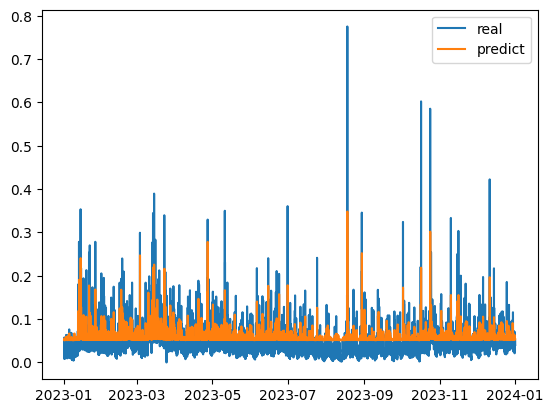

In [14]:
plt.plot(nf['hour_e_time'], nf['real'], label = 'real')
plt.plot(nf['hour_e_time'], nf['predict'], label = 'predict')
plt.legend()